# Validation of timezones in the timeline definition file

To validate, whether timezones declared in the timeline configuration
file are correct, plot ambient illumination in cages on a background indicating the "dark"
phases.

## Environment set up
At the beginning download and load into the memory the original data and the experiment timeline config file (see tutorials on basic and advanced topics for details).

_`data`_ and _`timeline`_ are considered to be global variables.

In [1]:
import pymice as pm

pm.getTutorialData(quiet=True)

import glob
dataFiles = glob.glob('C57_AB/*.zip')

loaders = [pm.Loader(filename, getEnv=True) for filename in dataFiles]
data = pm.Merger(*loaders, getEnv=True)

timeline = pm.ExperimentTimeline('C57_AB/timeline.ini')

PyMICE library v. 0.2.2
(NeuroLex.org ID: nlx_158570)

This is a bleeding edge version of the library. It might meet your
expectations, however it might also go to your fridge, drink all the
beer it can find there and then eat your cat. Be warned.



## Period of interest definition

For convenience limit the validation to the first four days of experiment - declare a global list of names of proper phases.

In [2]:
PHASES = ['SA 1 dark', 'SA 1 light',
          'SA 2 dark', 'SA 2 light',
          'SA 3 dark', 'SA 3 light',
          'SA 4 dark', 'SA 4 light',]

## Results visualisation details

** Stuff covered in this section might be important mainly for you if you want to improve your Python programminng skills. **

Define a context manager class _`DecoratedAxes`_ providing you with a preprocessed _`matplotlib.axes.Axes`_ object and taking care for details like providing legend after the plotting is finished.

In [3]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pytz

CET = pytz.timezone('CET')

class DecoratedAxes(object):
    def __enter__(self):
        fig, ax = plt.subplots(figsize=(13, 8))

        ax2 = ax.twiny()
        
        ax.set_ylim(-5, 255)
        ax.set_xlim(getTimeBounds(PHASES))
        ax2.set_xlim(getTimeBounds(PHASES))
        
        ax.set_ylabel('ambient luminance')
        ax.set_xlabel('time')
        ax2.set_xlabel('experiment timeline')

        ax.xaxis.set_major_locator(mpd.HourLocator([1, 13], tz=CET))
        ax.xaxis.set_major_formatter(mpd.DateFormatter('%d.%m %H:%M', tz=CET))

        self.ax = ax
        self.ax2 = ax2
        self.fig = fig

        return ax, ax2

    def __exit__(self, type, value, traceback):
        self.ax.legend(loc='lower right')
        self.ax.autoscale_view()

## Background plotting

Define a function _`plotBackground()`_, plotting dark background for a timespan of phases which names end with "dark".

In [4]:
def plotBackground(ax):
    for phase in PHASES:
        if phase.endswith('dark'):
            start, end = getTimeBounds(phase)
            ax.axvspan(start, end, color='#E0E0E0')

To convert name(s) of phase(s) into pair of its/theirs boundaries in _`matplotlib.dates`_ reference space define an auxilary function _`getTimeBounds()`_.
For transformation of _`datetime.datetime`_ objects into the space of the time axis, use _`matplotlib.dates.date2num()`_ function.

Define also another auxilary function - _`getPhaseMidtime()`_ - determining the location of phase's midptime in the space of the time axis.

In [5]:
import matplotlib.dates as mpd

def getTimeBounds(phases):
    return mpd.date2num(timeline.getTime(phases))

def getPhaseMidtime(phase):
    return getTimeBounds(phase).mean()

## Labelling axis with names of phases

Use the _`timeline`_ object as an axis formatter to label midpoint of each phase with its name.

In [6]:
def addPhaseLabels(ax):
    ax.xaxis.set_major_formatter(timeline)
    ax.set_xticks(list(map(getPhaseMidtime, PHASES)))

## Ploting ambient illumination

To plot the illumination in separate cages you need to select samples with appropriate value of the _`.Cage`_ attribute, then you need to extract their _`.DateTime`_ and _`.Illumination`_ attributes.

In [7]:
def selectCageSamples(cage, samples):
    return [s for s in samples if s.Cage == cage]

def getTime(environment):
    return mpd.date2num([e.DateTime for e in environment])

def getIllumination(environment):
    return [e.Illumination for e in environment]

def plotLuminance(ax, environment, label):
    ax.plot(getTime(environment), getIllumination(environment),
            label=label, ls='None', marker='.')

## Drawing the plot

Combine all written code together and draw the plot.

If the timezones are correct, the luminance's value should be synchronized with phases.

%matplotlib magic command is for purpose of the ipython notebook only.

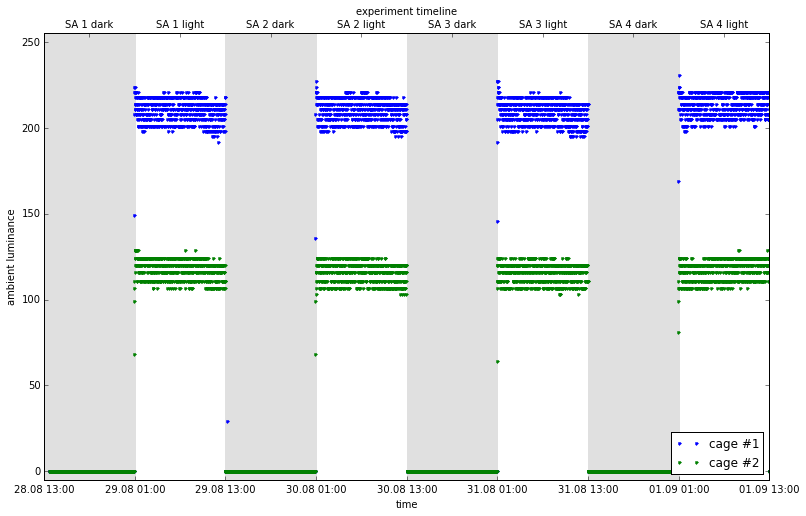

In [8]:
%matplotlib inline

with DecoratedAxes() as (bottomAx, topAx):
    plotBackground(bottomAx)
    addPhaseLabels(topAx)

    environment = data.getEnvironment()
    for cage in [1, 2]:
        plotLuminance(bottomAx, selectCageSamples(cage, environment),
                      label='cage #{}'.format(cage))

You might observe a great variance of luminance - we suspect it is an aliasing effect caused by low sampling rate
(and low inertia of luminance sensor) combined with a fluorescent lamp used as a light source.